# Учебный Проект → «ГлавРосГосНефть»

## Описание Проекта

<div class="alert alert-info" role="alert">
    <span style="font-size:0.7rem">Student's note</span>
    <p class="mb-0">В коде использую <code>display()</code> намеренно, потомучто это однозначно даёт понять что планируется вывод / печать результатов. 👌</p>
</div>

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.
Шаги для выбора локации обычно такие:

1. В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
2. Строят модель для предсказания объёма запасов в новых скважинах;
3. Выбирают скважины с самыми высокими оценками значений;
4. Определяют регион с максимальной суммарной прибылью отобранных скважин;

Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.

### Условия задачи

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузите и подготовьте данные. Поясните порядок действий.

Импортируем библиотеки 🎒

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import rcParams

from math import sqrt

from statistics import mean
from statistics import stdev

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline

Настроим вид графиков по+красоте ✨

In [2]:
%config InlineBackend.figure_formats = ['svg']

In [3]:
# style MATPLOTLIBRC
custom_params = {
                'figure.figsize': (10, 6),
                'figure.facecolor': '#232425',
                'figure.dpi': 240,

                'legend.frameon': False,
                'legend.borderpad': 1.4,
                'legend.labelspacing': 0.7,
                'legend.handlelength': 0.7,
                'legend.handleheight': 0.7,

                'axes.facecolor': '#232425',
                'axes.labelcolor': '#EEEEEE',
                'axes.labelpad': 17,
                'axes.spines.left': False,
                'axes.spines.bottom': False,
                'axes.spines.right': False,
                'axes.spines.top': False,
                'axes.grid': False,

                'contour.linewidth': 0.0,

                'xtick.color': '#AAAAAA',
                'ytick.color': '#AAAAAA',
                'xtick.bottom': True,
                'xtick.top': False,
                'ytick.left': True,
                'ytick.right': False,
    
                "lines.color": '#EEEEEE',

                'text.color': '#EEEEEE',
    
                'font.family': 'sans-serif',
                # 'font.sans-serif': [
                #     'Helvetica',
                #     'Verdana',
                #     'Tahoma',
                #     'Trebuchet MS',
                #     'Arial',
                #     'Chevin'
                #     ]
                }

# rcParams.update(custom_params)

Константы.

In [4]:
random_seed = 108108108
dpi_k = custom_params['figure.dpi'] / rcParams['figure.dpi']
px = 1/custom_params['figure.dpi']

Функции.

In [5]:
def to_px(size_px):
    px_density = int(
        round(
            size_px * px * dpi_k
        )
    )
    return px_density

In [6]:
def plot_hist(geo_data, title='Histogram', custom_params=custom_params):
    with mpl.rc_context(custom_params):
        fig, axs = plt.subplots(
            nrows=1,
            ncols=4,
            figsize=(
                to_px(1024), to_px(256)),
            tight_layout=True
        )
        
        n_bins = int(len(geo_data.index) / 100)
        
        for n in range(4):
            col_name = geo_data.columns[n]
            axs[n].hist(geo_data[col_name], bins=n_bins, color='forestgreen')
            axs[n].set_title(col_name)
        
        fig.suptitle(title)

        plt.show()

In [7]:
def baisic_df_info(data_df, title='Basic Info'):
    print(title, end='\n\n')
    print('Дубликатов:',
             len(data_df.loc[data_df.duplicated()].index),
          end='\n\n'
     )
    
    display(
        data_df.info(),
        data_df.sample(5),
        data_df.describe(),
    )

In [78]:
def predict_info(target_valid, target_pred, region_name):
    print('Регион', region_name, end='\n\n')
    print('Предсказания запасов нефти:')
    print(
        '\tсреднее',
        round(np.mean(target_pred), 5)
    )
    print(
        '\tмедиана',
        round(np.median(target_pred), 5)
    )
    print()
    print(
        'RMSE модели',
        sqrt(
            mean_squared_error(
                target_valid,
                target_pred
            )
        )
    )

Загрузим данные.

In [8]:
try:
    geo_data_zero = pd.read_csv(
        './datasets/geo_data_0.csv',
        index_col='id',
    )
    geo_data_one = pd.read_csv(
        './datasets/geo_data_1.csv',
        index_col='id',
    )
    geo_data_two = pd.read_csv(
        './datasets/geo_data_2.csv',
        index_col='id',
    )
    
except FileNotFoundError:
    geo_data_zero = pd.read_csv(
        'https://code.s3.yandex.net/datasets/geo_data_0.csv',
        index_col='id',
    )
    geo_data_one = pd.read_csv(
        'https://code.s3.yandex.net/datasets/geo_data_1.csv',
        index_col='id',
    )
    geo_data_two = pd.read_csv(
        'https://code.s3.yandex.net/datasets/geo_data_2.csv',
        index_col='id',
    )
    print('FYI datasets loaded via url')

Посмотрим на данные 📊

- `id` — уникальный идентификатор скважины
- `f0`, `f1`, `f2` — три значимых признака точек
- `product` — объём запасов в скважине, (тыс. баррелей)

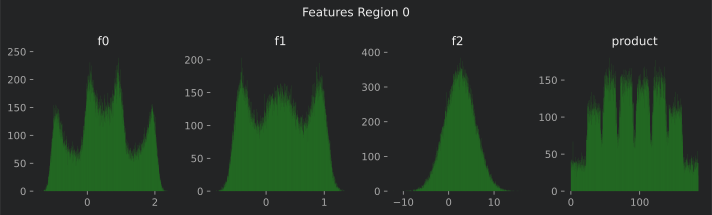

In [9]:
plot_hist(geo_data_zero, title='Features Region 0')

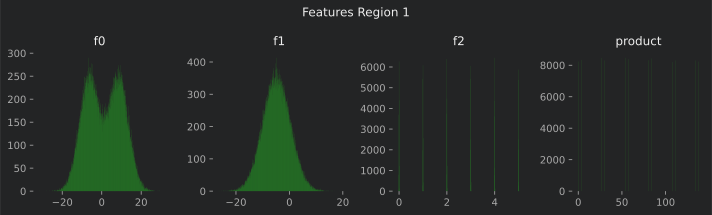

In [10]:
plot_hist(geo_data_one, title='Features Region 1')

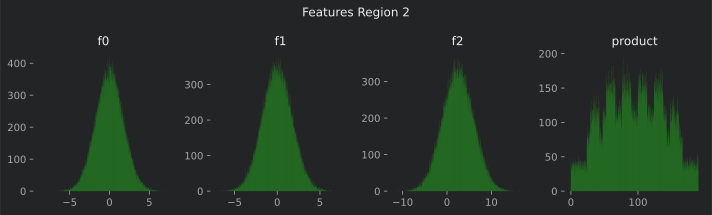

In [11]:
plot_hist(geo_data_two, title='Features Region 2')

In [12]:
baisic_df_info(geo_data_zero, 'Region 0')

Region 0

Дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


None

f0        f1        f2     product
id                                             
YefVV  0.697468  0.707367  2.632307  113.022438
zTLfR  0.846599  0.358964 -0.017714   34.176549
SOJGi  0.816668 -0.396309  4.831208  130.801898
3MkIu  1.486978 -0.298397 -1.854001   86.306248
indl2  1.099589  0.406456  1.850055  103.084111

f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347

In [13]:
baisic_df_info(geo_data_one, 'Region 1')

Region 1

Дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


None

f0         f1        f2     product
id                                               
s1nID   5.508013  -5.089360  4.009969  107.813044
h3pOI  -5.711130 -12.647118  4.003053  110.992147
37WB2   8.771631 -19.011470  2.997907   80.859783
8uT8s  12.886192  -2.098659  4.998533  134.766305
tLtFp  11.808830  -9.942528  3.994411  107.813044

f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%         1.153055      -4.813172       2.011479      57.085625
75%         8.621015      -1.332816       3.999904     107.813044
max        29.421755      18.734063       5.019721     137.945408

In [14]:
baisic_df_info(geo_data_two, 'Region 2')

Region 2

Дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


None

f0        f1        f2     product
id                                             
SCpvG  0.137465 -0.175517  0.814433   64.444884
7tz24  1.146232 -0.589915  4.285864  102.303270
IjGj5  2.130814 -2.024036  0.360160   96.710479
IAV7P -0.613917  0.496506  4.241746  127.901031
dVGDj  0.854113 -0.558529  3.153399  127.090363

f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0.000000
25%        -1.162288      -1.174820       0.130359      59.450441
50%         0.009424      -0.009482       2.484236      94.925613
75%         1.158535       1.163678       4.858794     130.595027
max         7.238262       7.844801      16.739402     190.029838

В **Первом** регионе распределение признака `f2` и `product` отличается от распределения признака `f2` и `product` **Нулевого** и **Второго** регионов.  
Выглядит так, что признаки не были стандартизованы + масштабированы. Потомучто `mean != 0`.  
  
Поэтому [пройдёмся нормализатором `MinMaxScaler` по регионам](#mm_scaler) 🎛️  
~~Для эксперимента [пройдёмся `StandardScaler` по регионам](#standard_scaler) 🎛️~~

<hr/>

## Обучите и проверьте модель для каждого региона

In [15]:
features_zero = geo_data_zero.drop('product', axis=1)
target_zero = geo_data_zero['product']

features_one = geo_data_one.drop('product', axis=1)
target_one = geo_data_one['product']

features_two = geo_data_two.drop('product', axis=1)
target_two = geo_data_two['product']

### Разделим данные на обучающую и валидационную выборки в соотношении 75:25

In [16]:
features_train_zero, features_valid_zero, target_train_zero, target_valid_zero = train_test_split(
    features_zero,
    target_zero,
    test_size=0.25,
    random_state=random_seed,
)

In [17]:
features_train_one, features_valid_one, target_train_one, target_valid_one = train_test_split(
    features_one,
    target_one,
    test_size=0.25,
    random_state=random_seed,
)

In [18]:
features_train_two, features_valid_two, target_train_two, target_valid_two = train_test_split(
    features_two,
    target_two,
    test_size=0.25,
    random_state=random_seed,
)

Объединим данные по регионам.

In [19]:
features_train = pd.concat(
    [features_train_zero,
     features_train_one,
     features_train_two],
    axis=0,
)

target_train = pd.concat(
    [target_train_zero,
     target_train_one,
     target_train_two],
)

In [20]:
features_train, target_train = shuffle(
    [features_train, target_train],
    random_state=random_seed,
    n_samples=None
)

<a id="mm_scaler"></a>
Нормализуем признаки `MinMaxScaler`

In [21]:
mm_scaler = MinMaxScaler()
mm_scaler.fit(features_train)

MinMaxScaler()

In [22]:
features_train = mm_scaler.transform(features_train)

features_valid_zero = mm_scaler.transform(features_valid_zero)
features_valid_one = mm_scaler.transform(features_valid_one)
features_valid_two = mm_scaler.transform(features_valid_two)

<a id="standard_scaler"></a>
~~Обучим `StandardScaler`~~ 💎

~~Применим `StandardScaler`~~ 💎

### Обучите модель и сделайте предсказания на валидационной выборке

In [23]:
lin_reg = LinearRegression()

In [24]:
# create a KFold object with 5 splits 
folds = KFold(
    n_splits=5,
    shuffle=True,
    random_state=random_seed
)
r2_scores = cross_val_score(
    lin_reg,
    features_train,
    target_train,
    scoring='r2',
    cv=folds
)
print(r2_scores)

[0.29954145 0.31320485 0.30552203 0.30771542 0.30185618]


**Значения когда признаки масштабированны `StandardScaler`**  
r2_scores = `[0.29954145 0.31320485 0.30552203 0.30771542 0.30185618]`  
r2_zero = 0.19128198005053276  
mse = 1578.4927393486362  
rmse = 39.730249676394386  

In [25]:
lin_reg.fit(features_train, target_train,)

LinearRegression()

### Сохраните предсказания и правильные ответы на валидационной выборке

In [30]:
target_pred_zero = lin_reg.predict(features_valid_zero)
r2_zero = r2_score(target_valid_zero, target_pred_zero)

print('r2_score\t', r2_zero)

r2_score	 0.19128198005053298


In [31]:
target_pred_one = lin_reg.predict(features_valid_one)
r2_one = r2_score(target_valid_one, target_pred_one)

print('r2_score\t', r2_one)

r2_score	 0.44300362832016316


In [32]:
target_pred_two = lin_reg.predict(features_valid_two)
r2_two = r2_score(target_valid_two, target_pred_two)

print('r2_score\t', r2_two)

r2_score	 0.12531454533407294


Похоже, что не доучили модель..  
Потомучто разница `r2_score` большая на `train` и `valid` выборках.   
Да и само значение `r2_score` низкое.

In [33]:
print('intercept\t', lin_reg.intercept_)
print('coefficients\t', lin_reg.coef_)

intercept	 -69.86322700706087
coefficients	 [-20.44403454  76.04061077 244.67001947]


#### Применим `PolynomialFeatures`

In [97]:
features_valid = np.concatenate(
    (features_valid_zero, features_valid_one, features_valid_two),
    axis=0
)

target_valid = np.concatenate(
    (target_valid_zero, target_valid_one, target_valid_two),
    axis=0

)

Пример со статьи на kaggle [Cross-Validation with Linear Regression](https://www.kaggle.com/code/jnikhilsai/cross-validation-with-linear-regression)

In [98]:
# fit multiple polynomial features
degrees = [1, 2, 3, 4, 5, 6, 7, 8]

# features_train
# target_train
# initialise y_train_pred and y_test_pred matrices to store the train and test predictions
# each row is a data point, each column a prediction using a polynomial of some degree
target_train_pred = np.zeros((len(features_train), len(degrees)))
target_valid_pred = np.zeros((len(features_valid), len(degrees)))

for i, degree in enumerate(degrees):
    
    # make pipeline: create features, then feed them to linear_reg model
    lin_reg_pol = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    lin_reg_pol.fit(features_train, target_train)
    
    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    target_train_pred[:, i] = lin_reg_pol.predict(features_train)
    target_valid_pred[:, i] = lin_reg_pol.predict(features_valid)

In [99]:
# compare r2 for train and test sets (for all polynomial fits)
print("R-squared values: \n")

for i, degree in enumerate(degrees):
    train_r2 = round(r2_score(target_train, target_train_pred[:, i]), 4)
    valid_r2 = round(r2_score(target_valid, target_valid_pred[:, i]), 4)
    print("Polynomial degree {0}: train score={1}, valid score={2}".format(
        degree, 
        train_r2, 
        valid_r2))


R-squared values: 

Polynomial degree 1: train score=0.3056, valid score=0.3042
Polynomial degree 2: train score=0.3809, valid score=0.3793
Polynomial degree 3: train score=0.4353, valid score=0.4347
Polynomial degree 4: train score=0.4541, valid score=0.4525
Polynomial degree 5: train score=0.4663, valid score=0.4652
Polynomial degree 6: train score=0.475, valid score=0.4707
Polynomial degree 7: train score=0.4802, valid score=0.4746
Polynomial degree 8: train score=0.4854, valid score=0.4739


~~**Пятая** степень выглядит обещающе~~, попробуем..
**Третья** степень повышает r2_score

In [165]:
lin_reg_pol = make_pipeline(
    PolynomialFeatures(degree=3),
    LinearRegression()
)
lin_reg_pol.fit(features_train, target_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('linearregression', LinearRegression())])

In [166]:
target_pred_zero = lin_reg_pol.predict(features_valid_zero)
r2_zero = r2_score(target_valid_zero, target_pred_zero)

print('r2_score\t', r2_zero)

r2_score	 0.22202073413356194


In [167]:
target_pred_one = lin_reg_pol.predict(features_valid_one)
r2_one = r2_score(target_valid_one, target_pred_one)

print('r2_score\t', r2_one)

r2_score	 0.7864671722703584


In [168]:
target_pred_two = lin_reg_pol.predict(features_valid_two)
r2_two = r2_score(target_valid_two, target_pred_two)

print('r2_score\t', r2_two)

r2_score	 0.1545301142431048


### Напечатайте на экране средний запас предсказанного сырья и RMSE модели

In [169]:
predict_info(
    target_valid_zero,
    target_pred_zero,
    'Нуль'
)

Регион Нуль

Предсказания запасов нефти:
	среднее 91.23941
	медиана 90.21388

RMSE модели 38.96787697943101


In [170]:
predict_info(
    target_valid_one,
    target_pred_one,
    'Первый'
)

Регион Первый

Предсказания запасов нефти:
	среднее 75.25112
	медиана 79.01819

RMSE модели 21.271459060442986


In [171]:
predict_info(
    target_valid_two,
    target_pred_two,
    'Второй'
)

Регион Второй

Предсказания запасов нефти:
	среднее 90.39426
	медиана 89.11522

RMSE модели 41.176624905727614


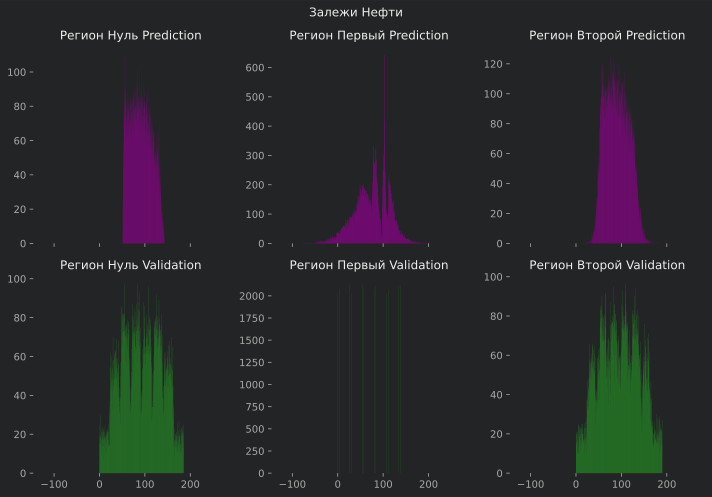

In [172]:
with mpl.rc_context(custom_params):
    fig, axs = plt.subplots(
        nrows=2,
        ncols=3,
        figsize=(
            to_px(960), to_px(720)),
        tight_layout=True,
        sharex=True,
        squeeze=False, 
    )

    n_bins = int(len(target_pred_zero) / 50)

    axs[0, 0].hist(target_pred_zero, bins=n_bins, color='darkmagenta')
    axs[0, 0].set_title('Регион Нуль Prediction')
    axs[1, 0].hist(target_valid_zero, bins=n_bins, color='forestgreen')
    axs[1, 0].set_title('Регион Нуль Validation')
    
    axs[0, 1].hist(target_pred_one, bins=n_bins, color='darkmagenta')
    axs[0, 1].set_title('Регион Первый Prediction')
    axs[1, 1].hist(target_valid_one, bins=n_bins, color='forestgreen')
    axs[1, 1].set_title('Регион Первый Validation')
    
    axs[0, 2].hist(target_pred_two, bins=n_bins, color='darkmagenta')
    axs[0, 2].set_title('Регион Второй Prediction')
    axs[1, 2].hist(target_valid_two, bins=n_bins, color='forestgreen')
    axs[1, 2].set_title('Регион Второй Validation')

    fig.suptitle('Залежи Нефти')

    plt.show()

MSE (средняя квадратичная ошибка) и RMSE (квадратный корень из средней квадратичной ошибки).

MAE (англ. mean absolute error)

Коэффициент детерминации, или метрика R2 (англ. coefficient of determination; R-squared), 

> - Значение метрики R2 равно единице только в одном случае, если MSE нулевое. Такая модель предсказывает все ответы идеально.
> - R2 равно нулю: модель работает так же, как и среднее.
> - Если метрика R2 отрицательна, качество модели очень низкое.
> - Значения R2 больше единицы быть не может.

Перевудём предсказания в `Series`

In [173]:
target_pred_zero = pd.Series(target_pred_zero)
target_pred_one = pd.Series(target_pred_one)
target_pred_two = pd.Series(target_pred_two)

In [174]:
display(
    target_pred_zero.describe(),
    target_pred_ser_one.describe(),
    len(target_pred_one[target_pred_one < 0].index),
    target_pred_two.describe(),
)

count    25000.000000
mean        91.239413
std         23.341655
min         51.019745
25%         71.609744
50%         90.213876
75%        109.720344
max        168.317206
dtype: float64

count    25000.000000
mean        76.603911
std         30.235970
min        -67.644657
25%         57.634160
50%         79.685918
75%         97.954464
max        155.323091
dtype: float64

765

count    25000.000000
mean        90.394259
std         25.741425
min         21.829997
25%         69.223346
50%         89.115219
75%        110.630561
max        184.590104
dtype: float64

### Проанализируем результаты

- Коэффициент детерминации `r2_score` для регионов «Нуль» и «Второй» довольно низкий 0,23 и 0,16.
- А корень из квадратичной ошибки `RMSE` для регионов «Нуль» и Второй» выше чем у «Первого» региона.
- Похоже, что «Первый» регион более понятен для модели, если смотреть по r2_score.
- С другой стороны в «Первом» регионе модель предсказывает даже отрицательные значения запасов нефти..
    - В 765 из 25 000 скважен получились отрицательные значения
    - Похоже, мы задолжали нефть Земле, придётся вернуть нефть на место)

<hr/>

## Подготовьтесь к расчёту прибыли

### Все ключевые значения для расчётов сохраните в отдельных переменных

### Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины

### Сравните полученный объём сырья со средним запасом в каждом регионе

### Напишите выводы по этапу подготовки расчёта прибыли

### 

<hr/>

## Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

### Выберите скважины с максимальными значениями предсказаний

### Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям

### Рассчитайте прибыль для полученного объёма сырья

### 

### 

<hr/>

## Посчитайте риски и прибыль для каждого региона

### Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли

### Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков

#### Убыток — это отрицательная прибыль 

### Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор

### 

<hr/>

## 

## Как будут проверять мой проект?

- Как вы готовите данные к обучению?
- Выполнили все шаги по инструкции?
- Все ли условия бизнеса учтены?
- Какие выводы об исследовании задачи делаете?
- Корректно ли выполнена процедура Bootstrap?
- Предложен ли регион для разработки скважин? Обоснован ли выбор?
- Не дублируете ли код?
- Следите ли за структурой проекта и поддерживаете ли аккуратность кода?